In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import string
import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Data Import

In [58]:
df_train_raw = pd.read_excel('Project Corpora/train.xlsx')

In [59]:
df_train_raw.head(5)

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


# Exploratory Analysis

In [60]:
df_train_raw.shape

(12496, 4)

In [61]:
# Count the number of empty values in each column
empty_counts = df_train_raw.isna().sum()
print(empty_counts) 

index          0
description    0
host_about     0
unlisted       0
dtype: int64


In [62]:
df_train_raw['unlisted'].value_counts()

unlisted
0    9033
1    3463
Name: count, dtype: int64

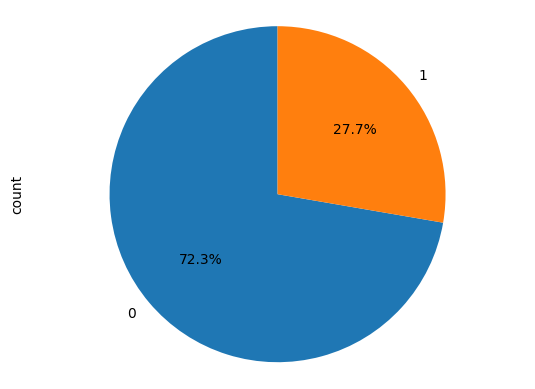

In [63]:
#df_train['unlisted'].pie()  # Classes are imbalanced !!!
# plot a pie chart for the 'count' column
df_train_raw['unlisted'].value_counts().plot(kind='pie', 
                                             labels=df_train_raw['unlisted'].unique(), 
                                             autopct='%1.1f%%', 
                                             startangle=90)
plt.axis('equal')
plt.show()

In [64]:
df_train_raw['description'].str.len().describe()

count    12496.000000
mean       814.679097
std        282.124598
min         12.000000
25%        625.000000
50%       1000.000000
75%       1000.000000
max       1000.000000
Name: description, dtype: float64

In [65]:
df_train_raw['host_about'].str.len().describe()

count    12496.000000
mean       439.562100
std        486.270567
min          1.000000
25%        152.000000
50%        325.000000
75%        612.000000
max       8683.000000
Name: host_about, dtype: float64

## Taking "description" only for the first iteration

In [66]:
df_train_raw.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


## Splitting data into Train and Validation

In [67]:
df_train_raw

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0
...,...,...,...,...
12491,12492,CAT’S BY BAIRRO ALTO<br /><br />This cozy apar...,Travelling is one of my favorite hobbies. I've...,0
12492,12493,Beautifully located in the heart of Lisbon's h...,Founded by travel enthusiasts (just like you) ...,0
12493,12494,Enjoy breakfast in the sleek kitchen with its ...,I´m from Portugal and I love to dance and to t...,0
12494,12495,A Terra da Eira é uma casa de campo rodeada de...,Somos uma familia de 5. Gostamos de viajar e d...,1


In [68]:
# Split the original train dataframe into training and validation sets
train_df, val_df = train_test_split(df_train_raw, test_size=0.2, random_state=42, 
                                    stratify=df_train_raw['unlisted']) # using stratify, to keep classes proportion

print('Shapes of train_df', train_df.shape)
print('Shapes of val_df', val_df.shape)

Shapes of train_df (9996, 4)
Shapes of val_df (2500, 4)


### Word Count

In [69]:
train_df.head()

,index,description,host_about,unlisted
7712,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0
11333,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1
3536,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0
4061,4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...",0
2742,2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...",0


In [70]:
# Fetch wordcount for each abstract
train_df['word_count']  = train_df['description'].apply(lambda x: len(str(x).split(" ")))
train_df[['description','word_count']].head()

,description,word_count
7712,"This exclusive villa, located in a quiet pinew...",167
11333,"Luna House B&B is part of the Luna House Hub, ...",167
3536,Newly refurbished apartment with swimming pool...,175
4061,Nice studio for two people with one bathroom a...,164
2742,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...",170


### Descriptive Statistics of word count

In [71]:
train_df.word_count.describe()

count    9996.000000
mean      132.795018
std        48.323208
min         3.000000
25%        99.000000
50%       157.000000
75%       167.000000
max       210.000000
Name: word_count, dtype: float64

<Axes: >

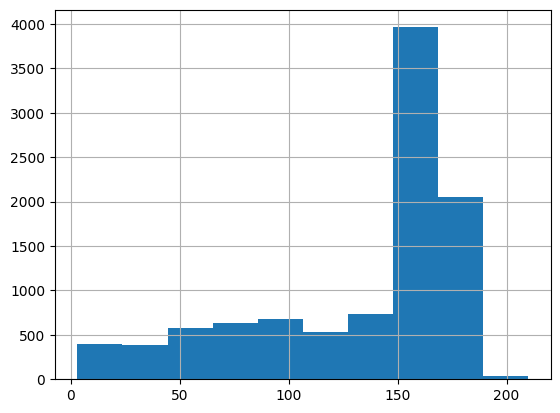

In [72]:
train_df['word_count'].hist()

In [73]:
all_words = ' '.join(train_df['description']).split()

In [74]:
freq = pd.Series(all_words).value_counts()

In [75]:
freq.sort_values(ascending=False)[0:10]

the      50115
and      43918
a        40453
/><br    27999
to       24560
of       24049
in       22402
with     21558
is       19192
de       11009
Name: count, dtype: int64

In [76]:
freq.index[0:10]

Index(['the', 'and', 'a', '/><br', 'to', 'of', 'in', 'with', 'is', 'de'], dtype='object')

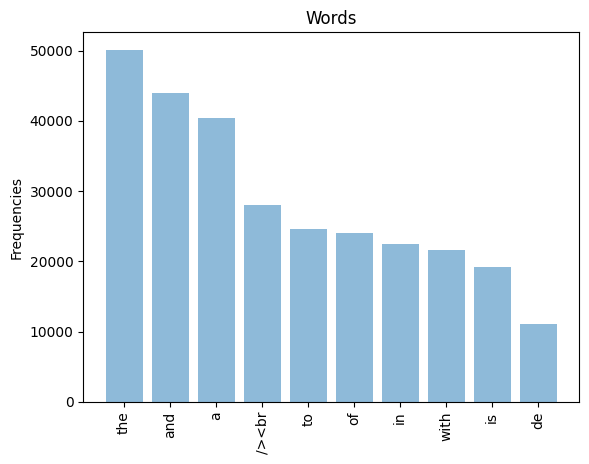

In [77]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
#plt.xticks(values, x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

# Preprocessing

In [78]:
stop = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
lemma = WordNetLemmatizer()

In [79]:
def clean(text_list, lemmatize, stemmer):   
    cleaned_text_list = []  
    for j in tqdm(text_list): 
        text = j
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA and PUNCTUATION
        text = re.sub("[^a-zA-Z]"," ", text )
        text = re.sub("br", "", text)
        
        #REMOVE STOPWORDS
        text = " ".join([word for word in text.split() if word not in stop])
        
        #Lemmatize
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        #Stemming
        if stemmer:
            text = " ".join(stemmer.stem(word) for word in text.split())
            
        cleaned_text_list.append(text)        
    return cleaned_text_list

In [80]:
cleaned_text_list = clean(train_df['description'], lemmatize = True, stemmer = False)

100%|█████████████████████████████████████████████████████████████████| 9996/9996 [00:01<00:00, 6001.64it/s]


In [81]:
cleaned_text_list

['exclusive villa located quiet pinewood area completely rebuilt recently near beautiful beach house private swimming pool large green area offer lot unforgettable moment peaceful place wake sound bird free wifi house b space b private villa floor lower level living room w dining area kitchen lavabo large entrance hall upstairs room bathroom shower outside relax patio kid play large green area around house recently added pool gate child security inside house also stair security b guest access b guest alone house garden pool door closed like garage private storage outside house close gate place car b',
 'luna house b b part luna house hub located close viant center cascais find nine spacious private bedroom carefully designed considering need digital nomad business traveler b space b wrapped inspiring room designed need bedroom made offer working space place get rest specially designed queen size bed high quality mattress bed linen feel ready day room located ground floor equipped ac wo

In [82]:
train_df

,index,description,host_about,unlisted,word_count
7712,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,167
11333,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,167
3536,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,175
4061,4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...",0,164
2742,2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...",0,170
...,...,...,...,...,...
8455,8456,This small but cozy historic apartment complet...,"We are a couple, born in Lisbon and we love li...",0,173
1691,1692,Fantastic double room in a quiet apartment in ...,_x000D_\nI´m a young enthusiastic music lover ...,0,131
8385,8386,"3 Bedrooms, 1 living and dining room, kitchen ...",Once upon a time there was just one house who ...,0,145
1500,1501,Situated on a prime location of Lisbon with hi...,Usually I say I’m “Alfacinha” (slang for Lisbo...,0,165


In [83]:
train_df['cleaned_text_list'] = cleaned_text_list
train_df

,index,description,host_about,unlisted,word_count,cleaned_text_list
7712,7713,"This exclusive villa, located in a quiet pinew...",We are a couple with a big family and we love ...,0,167,exclusive villa located quiet pinewood area co...
11333,11334,"Luna House B&B is part of the Luna House Hub, ...","Luna House B&B is part of the Luna House Hub, ...",1,167,luna house b b part luna house hub located clo...
3536,3537,Newly refurbished apartment with swimming pool...,World citizen looking forward to meet new peop...,0,175,newly refurbished apartment swimming pool stun...
4061,4062,Nice studio for two people with one bathroom a...,"Hello, I’m Antonio and I want to welcome you i...",0,164,nice studio two people one bathroom compact ki...
2742,2743,"WHETHER FOR A SHORTER OR LONGER STAYS, I WANT ...","My name is Alexandre, I live in Lisbon and I l...",0,170,whether shorter longer stay want offer solutio...
...,...,...,...,...,...,...
8455,8456,This small but cozy historic apartment complet...,"We are a couple, born in Lisbon and we love li...",0,173,small cozy historic apartment completely renov...
1691,1692,Fantastic double room in a quiet apartment in ...,_x000D_\nI´m a young enthusiastic music lover ...,0,131,fantastic double room quiet apartment lapa hou...
8385,8386,"3 Bedrooms, 1 living and dining room, kitchen ...",Once upon a time there was just one house who ...,0,145,bedroom living dining room kitchen bathroom ca...
1500,1501,Situated on a prime location of Lisbon with hi...,Usually I say I’m “Alfacinha” (slang for Lisbo...,0,165,situated prime location lisbon historic buildi...


In [84]:
"""
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"description": list_updated}))
    
x_train = x_train.drop(['word_count'], axis=1)
update_df(x_train, updates)
x_train
"""

'\ndef update_df(dataframe, list_updated):\n    dataframe.update(pd.DataFrame({"description": list_updated}))\n    \nx_train = x_train.drop([\'word_count\'], axis=1)\nupdate_df(x_train, updates)\nx_train\n'

# Define training features - Bag of Words (Bow)
Each word is a feature. Our feature space is defined by our vocabulary. Documents/pieces of text will be represented as sparse vectors.

### Create BoW from train corpus

In [85]:
bow = CountVectorizer(binary=True)

x_train = bow.fit_transform(train_df["cleaned_text_list"])

In [86]:
y_train = train_df['unlisted']

# Train Classifier

In [87]:
modelknn = KNeighborsClassifier(n_neighbors = 7, 
                                metric = 'cosine', 
                                weights = 'distance')

In [88]:
modelknn.fit(x_train, y_train)

KNeighborsClassifier(metric='cosine', n_neighbors=7, weights='distance')

# Predict for Val corpus

In [89]:
#update_df(x_val, clean(x_val['description'], lemmatize = True, stemmer = False))

In [90]:
val_df

,index,description,host_about,unlisted
4768,4769,This charming apartment on the first floor of ...,"Easygoing person, always ready to present the ...",0
4384,4385,Charming villa with a private pool and tennis ...,Allure Villas is your go-to spot for renting V...,1
11857,11858,One bedroom apartment inside a modern developm...,"Hey, this is Goncalo and Miku, your hosts in L...",0
1281,1282,"Apartment in the heart of the city, between Pr...","Hi!\n\nI'm Laura, I'm 32yo, and I live with my...",0
2133,2134,Amazing flat with two bedrooms in Restauradore...,We are Feels Like Home Holiday Rentals.\nA com...,0
...,...,...,...,...
2648,2649,"Set in a stunning seaside location, this luxur...",Going someplace new is always exciting. And wh...,0
9002,9003,The apartment in Lisbon has 2 bedrooms and has...,We are Feels Like Home Holiday Rentals.\nA com...,0
8678,8679,"Junto ao Palácio de S. Bento, e á assembleia d...","Olá sou o João, e estou á vossa espera para lh...",0
5770,5771,"The apartment is very homely, and it was thoug...",Hi there! We are The Mojo Team (MCPP Investme...,0


In [91]:
val_df['cleaned_text_list'] = clean(val_df['description'], lemmatize = True, stemmer = False)
val_df.head()

100%|█████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 5954.80it/s]


,index,description,host_about,unlisted,cleaned_text_list
4768,4769,This charming apartment on the first floor of ...,"Easygoing person, always ready to present the ...",0,charming apartment first floor typical cascais...
4384,4385,Charming villa with a private pool and tennis ...,Allure Villas is your go-to spot for renting V...,1,charming villa private pool tennis table withi...
11857,11858,One bedroom apartment inside a modern developm...,"Hey, this is Goncalo and Miku, your hosts in L...",0,one bedroom apartment inside modern developmen...
1281,1282,"Apartment in the heart of the city, between Pr...","Hi!\n\nI'm Laura, I'm 32yo, and I live with my...",0,apartment heart city pr ncipe real chiado bair...
2133,2134,Amazing flat with two bedrooms in Restauradore...,We are Feels Like Home Holiday Rentals.\nA com...,0,amazing flat two bedroom restauradores lisbon ...


In [92]:
X_val = bow.transform(val_df['cleaned_text_list'])
y_val = np.array(val_df['unlisted'])

#X = df_train[['description']]
#y = df_train['unlisted']

In [93]:
y_pred = modelknn.predict(X_val)

# Evaluate

In [94]:
labels = {"listed":0, "unlisted":1}
print(classification_report(y_pred, y_val, target_names = labels.keys()))

              precision    recall  f1-score   support

      listed       0.89      0.81      0.85      1991
    unlisted       0.45      0.62      0.52       509

    accuracy                           0.77      2500
   macro avg       0.67      0.71      0.69      2500
weighted avg       0.80      0.77      0.78      2500



In [95]:
confusion_matrix(y_pred, y_val)

array([[1613,  378],
       [ 194,  315]])

In [96]:
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    #plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    #plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

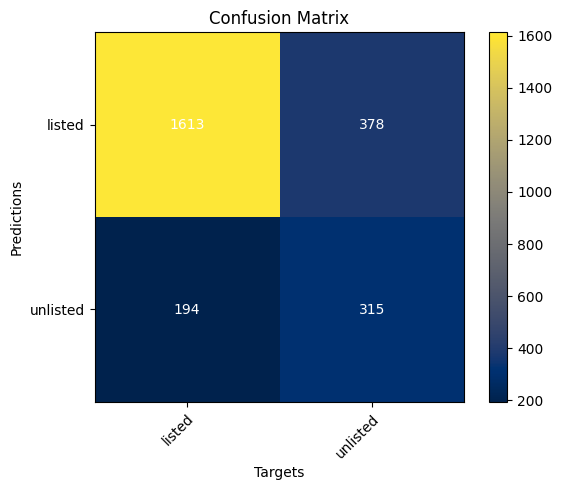

In [97]:
plot_cm(confusion_matrix(y_pred, y_val), labels.keys())